In [2]:
library("brms")
library("dplyr")
library("bayesplot")
library("rstanarm")
library("ggplot2")
library("rstan")
library("tidyr")
library("ggpubr")
library("projpred")
library("corrplot")
library("loo")
library("tidyverse")
library("here")
library("knitr")
library("walker")
library("tidybayes")
library("broom")
library("ggridges")
library("cmdstanr")
library("reshape2")
library("lubridate")
library("hrbrthemes")
library("viridis")
library('ggthemes')
options(repr.plot.width=12, repr.plot.height=12)

In [3]:
#https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads#using-or-publishing-our-price-paid-data
#     Postcode
#     PAON Primary Addressable Object Name. Typically the house number or name.
#     SAON Secondary Addressable Object Name. If there is a sub-building, for example, the building is divided into flats, there will be a SAON.
#     Street
#     Locality
#     Town/City
#     District
#     County

In [4]:
set_cmdstan_path("/Users/thomasmellan/Documents/cmdstan/")
path <- "/Users/thomasmellan/Documents/houseprices/"
df_hp_original <- read.csv(paste0(path,"pp-2020.csv"))

CmdStan path set to: /Users/thomasmellan/Documents/cmdstan



In [6]:
#df_hp <- head(df_hp_original,100)
df_hp <- df_hp_original
df_hp <- na.omit(df_hp)
colnames(df_hp) <- c("POAN","PricePaid","Date","Postcode",
                     "c1","c2","c3",
                     "a1","a2","a3","a4","a5","a6","a7",
                     "u1","u2")
# c1..3: some kind of code, to be googled
# a1..7: address parts
# u1..2: unknown, to be googled
df_hp$Date <- ymd(as.Date(df_hp$Date))

minPrice <- 100000  #100g
maxPrice <- 1000000 #2mil
df_hp <- df_hp[df_hp$PricePaid > minPrice & df_hp$PricePaid < maxPrice,]

df.gb <- df_hp
df.ldn <- df_hp[df_hp$a5 == "LONDON",]

df.ldn$Month <- as.factor(month(df.ldn$Date))
df.ldn.tmp <- df.ldn[c("PricePaid","Month")]

summary(df.ldn[c("PricePaid","Date")])
summary(df.gb[c("PricePaid","Date")])

   PricePaid           Date           
 Min.   :100500   Min.   :2020-01-02  
 1st Qu.:362581   1st Qu.:2020-02-19  
 Median :479950   Median :2020-04-03  
 Mean   :509966   Mean   :2020-04-27  
 3rd Qu.:640000   3rd Qu.:2020-07-10  
 Max.   :999999   Max.   :2020-10-23  

   PricePaid           Date           
 Min.   :100031   Min.   :2020-01-01  
 1st Qu.:173000   1st Qu.:2020-02-21  
 Median :250000   Median :2020-04-24  
 Mean   :297234   Mean   :2020-05-03  
 3rd Qu.:370000   3rd Qu.:2020-07-17  
 Max.   :999999   Max.   :2020-10-29  

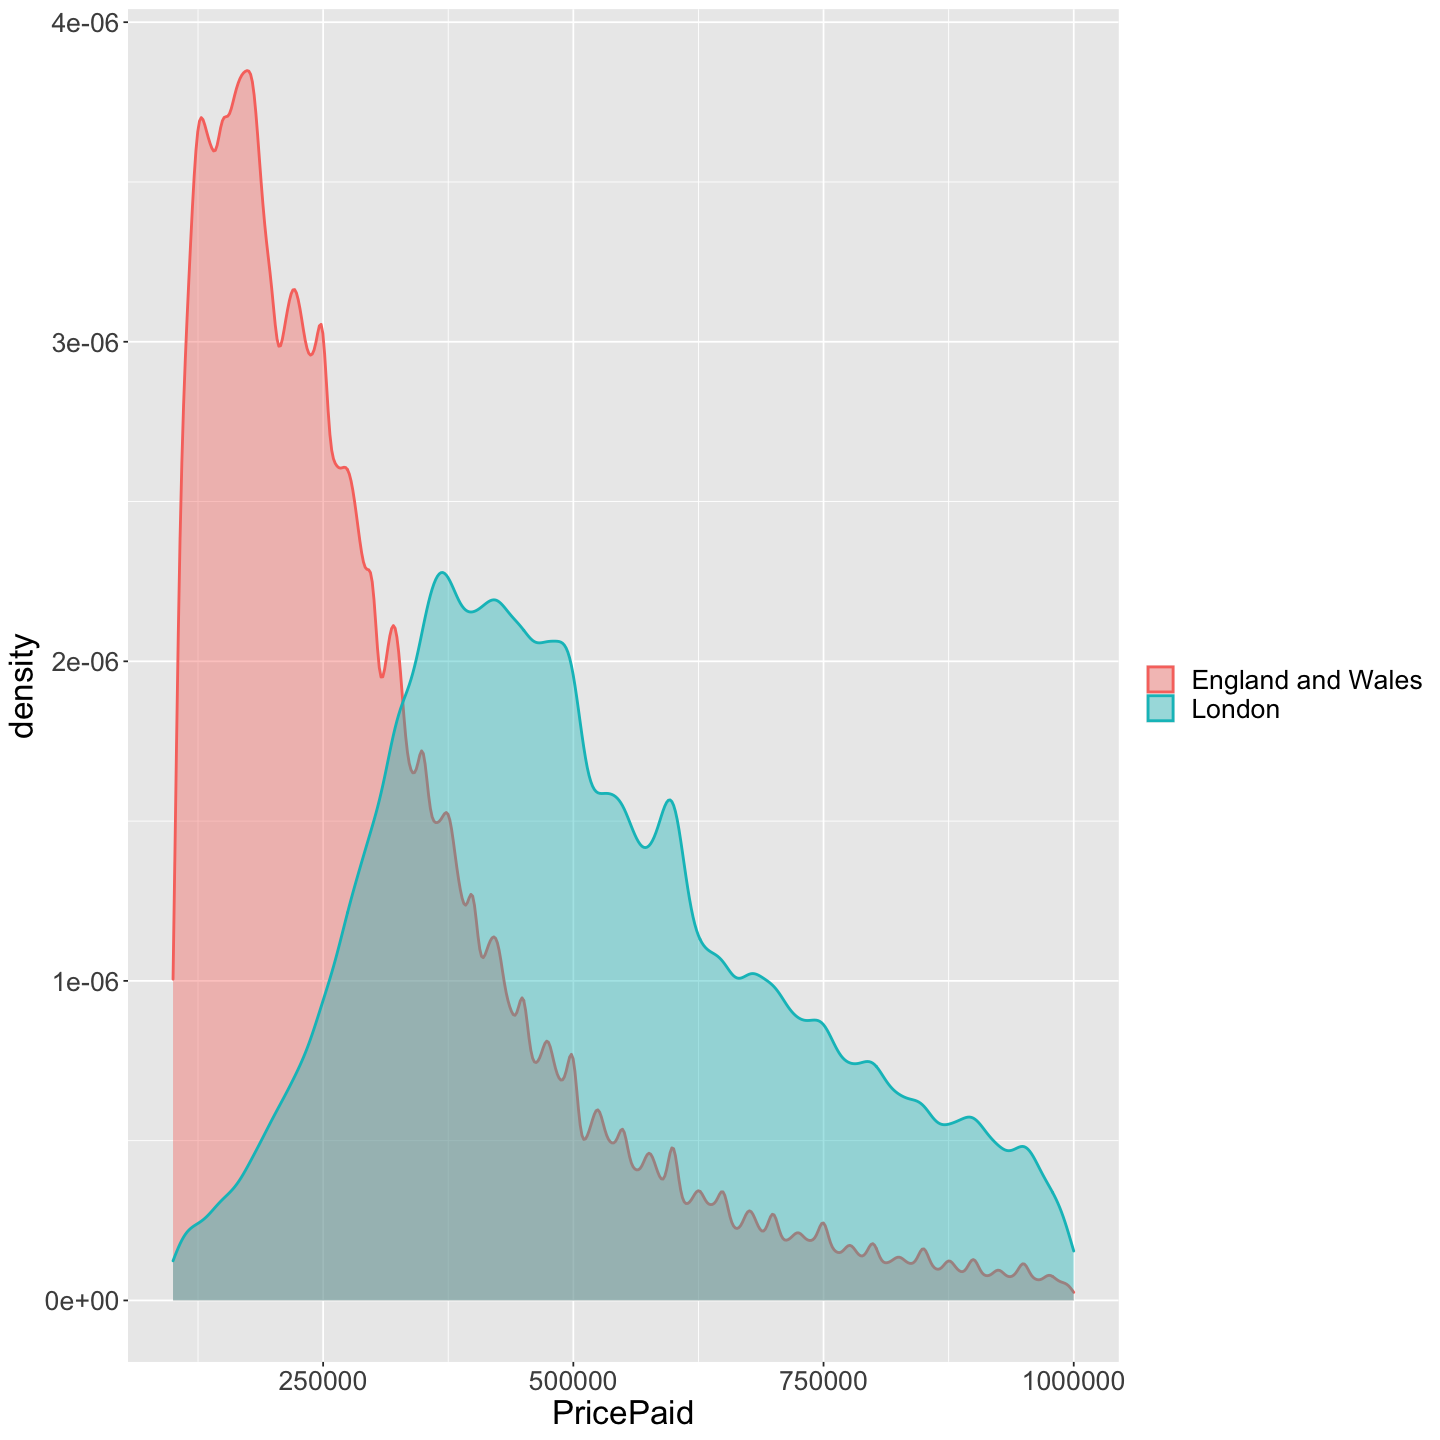

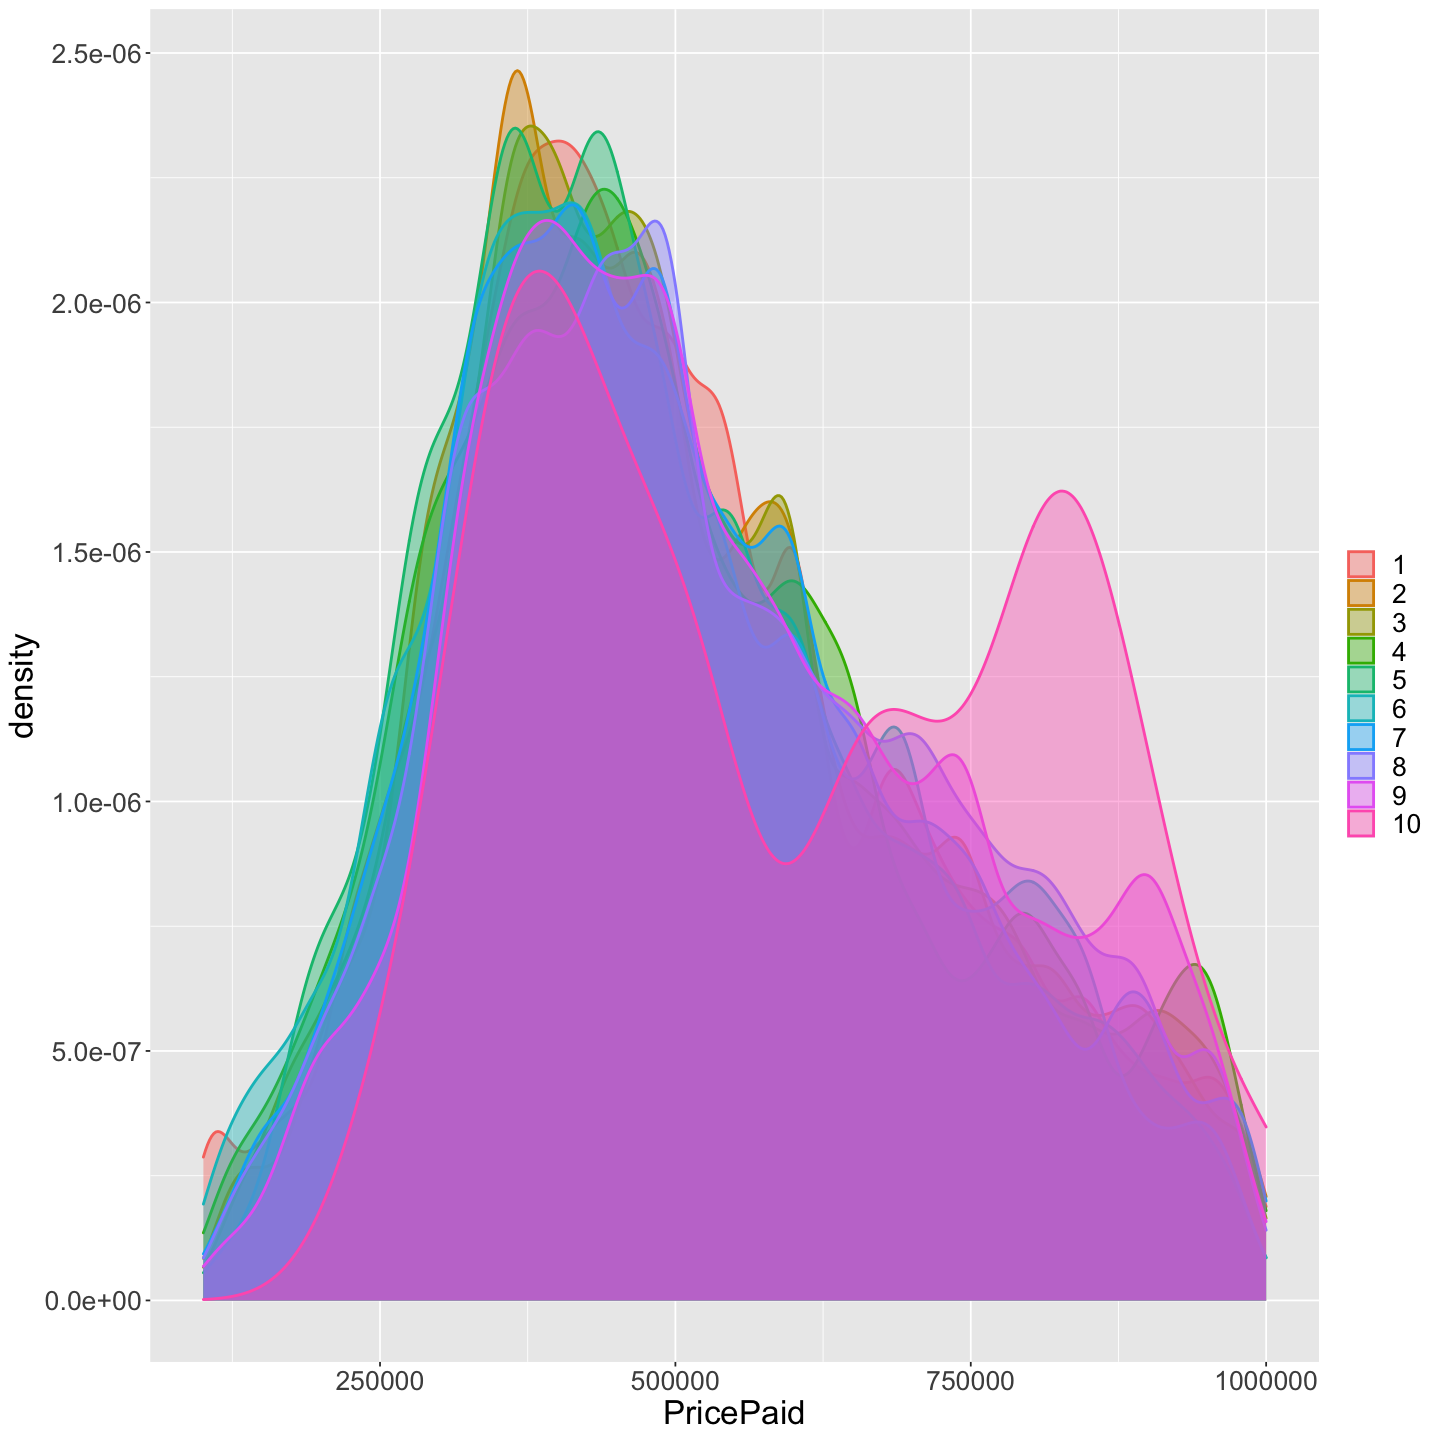

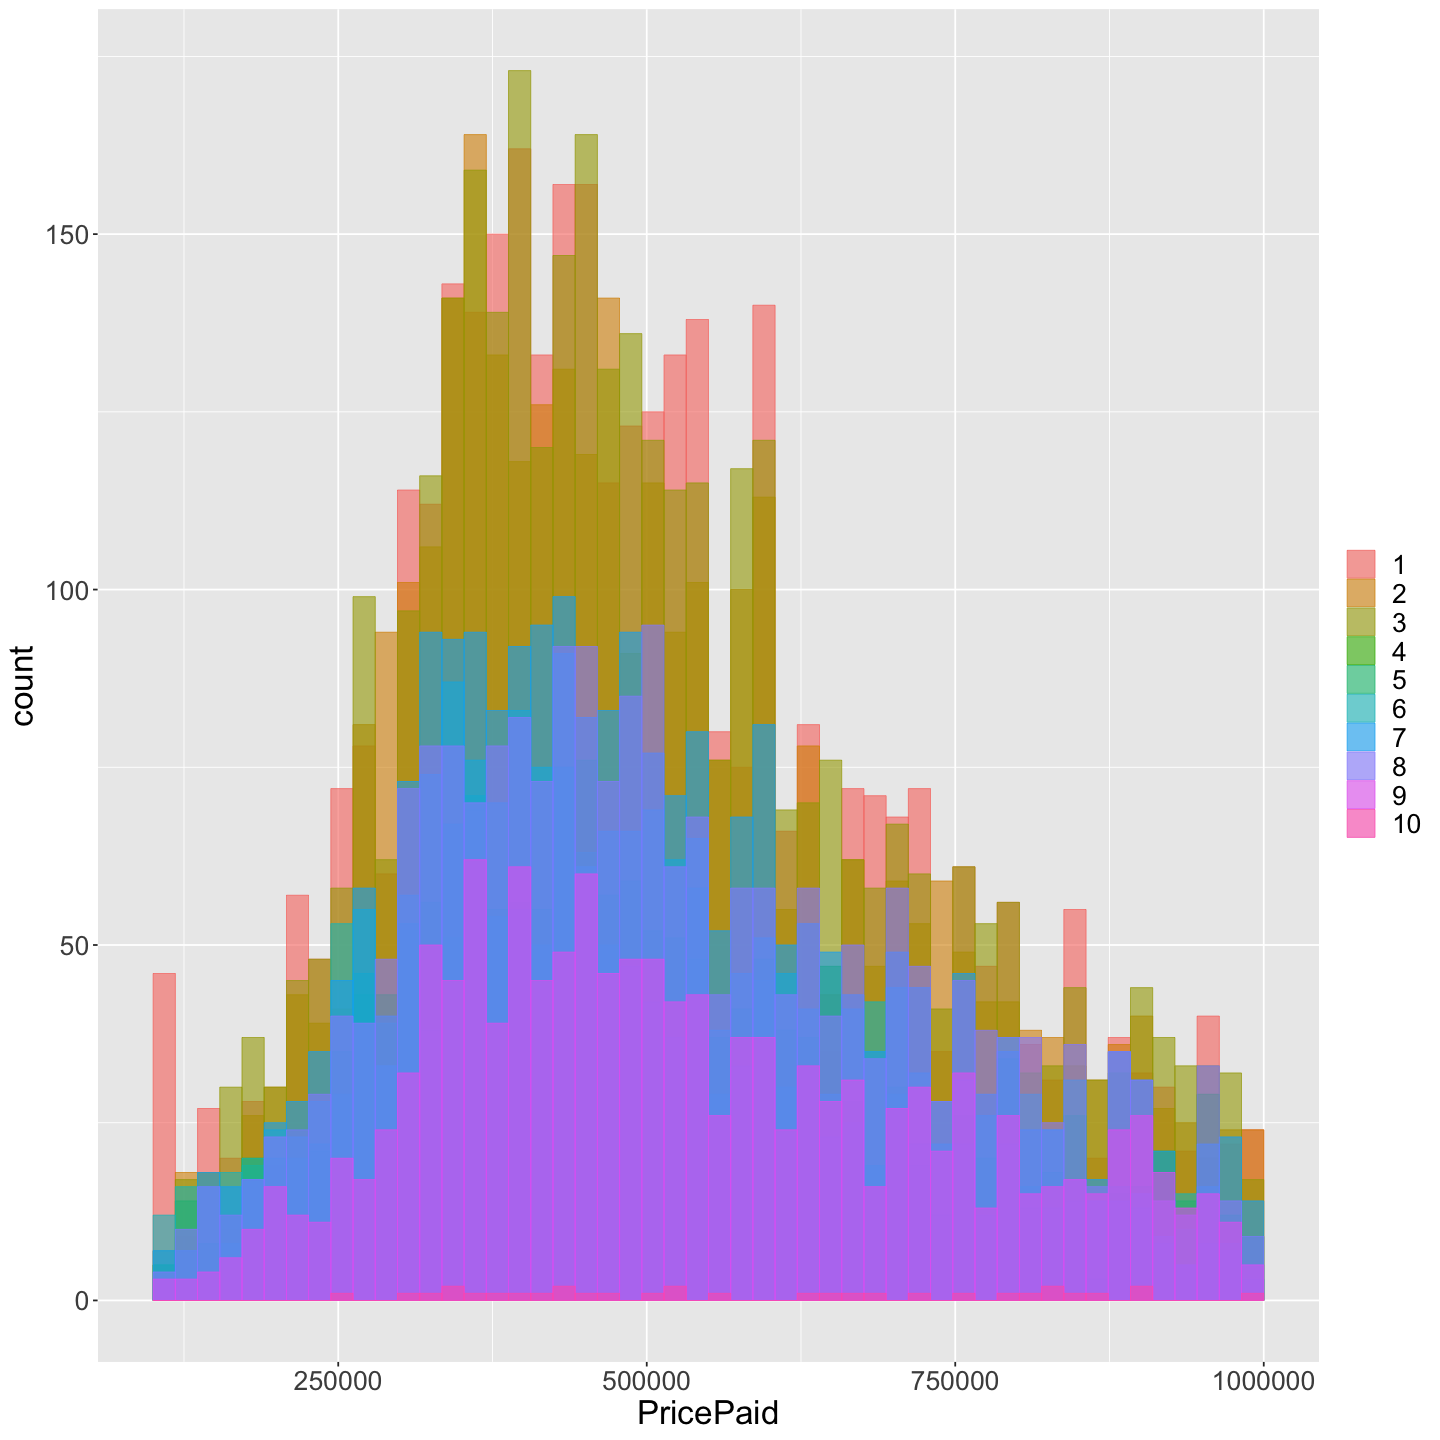

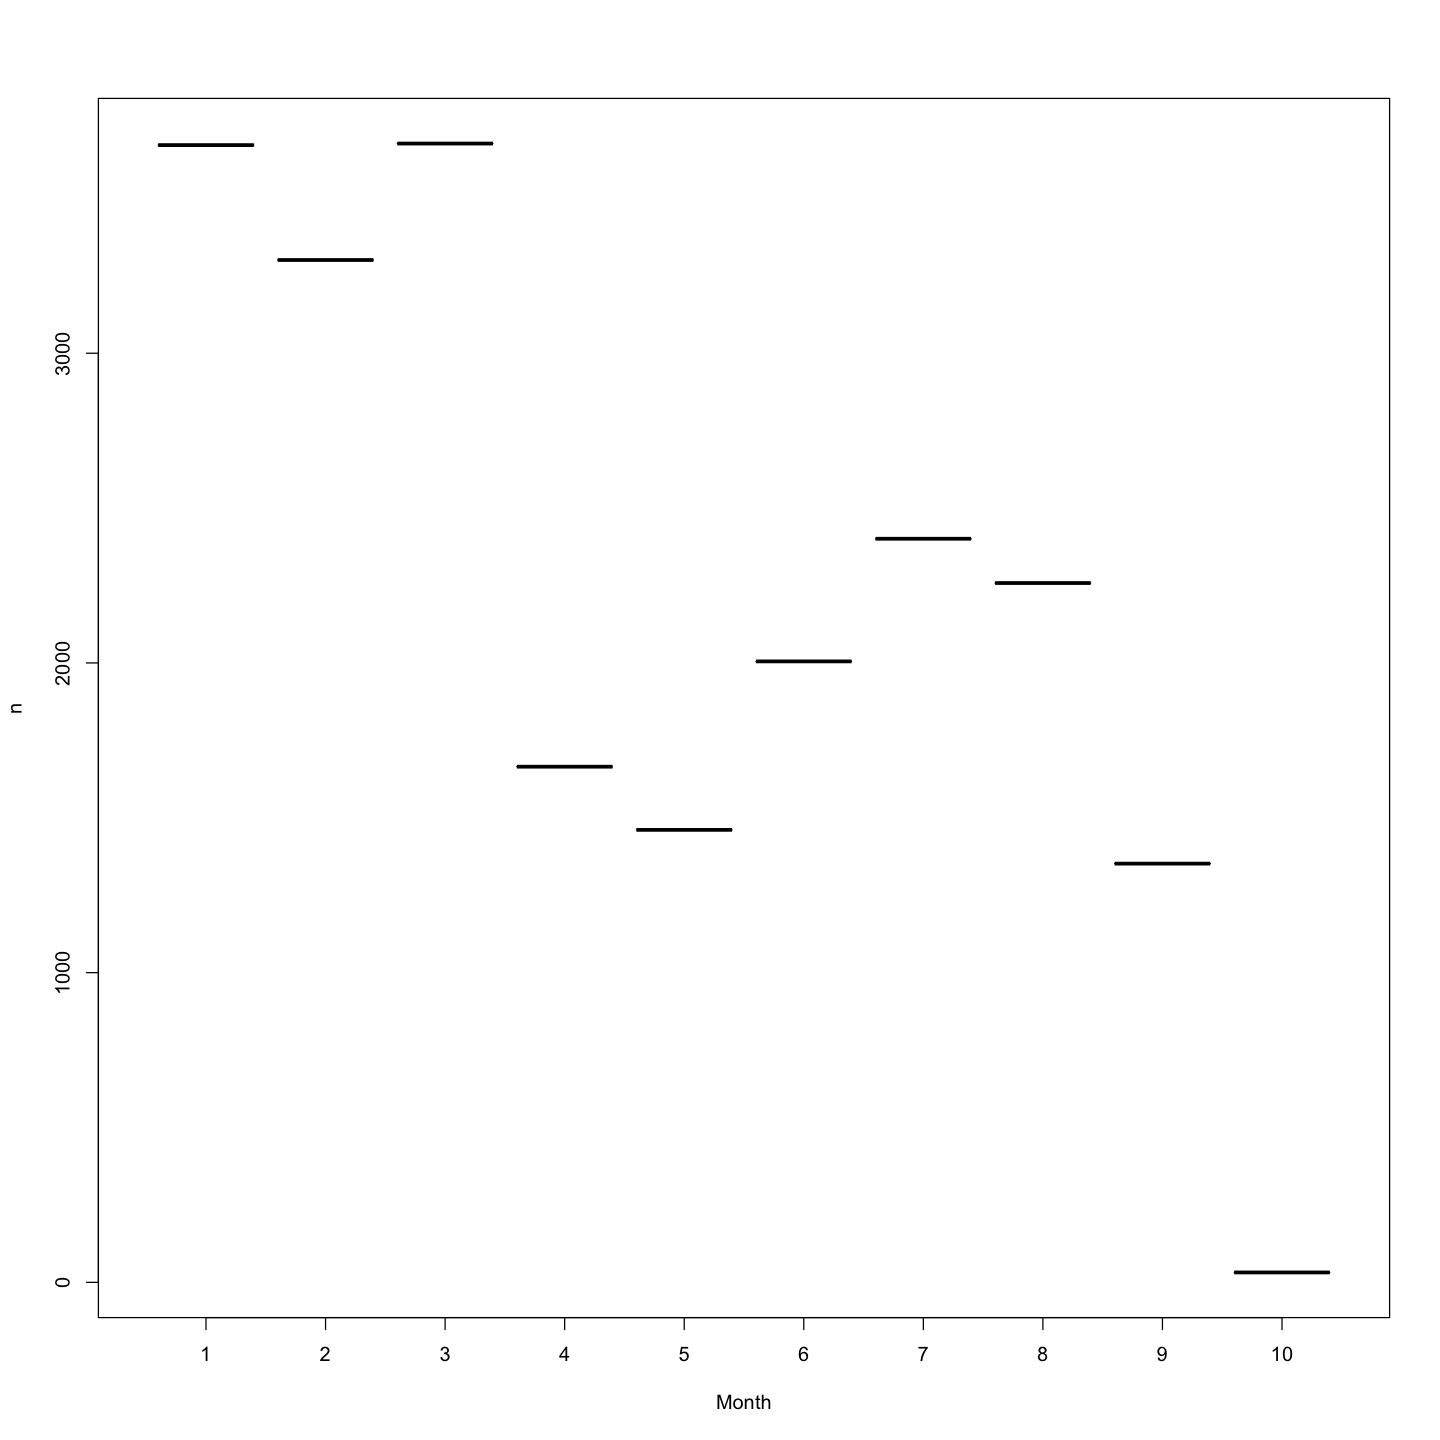

In [9]:
dat1 = data.frame(PricePaid = df.ldn$PricePaid, group="London")
dat2 = data.frame(PricePaid = df.gb$PricePaid, group="England and Wales")
dat = rbind(dat1, dat2)

ggplot(dat, aes(PricePaid, fill=group, colour=group)) +
    geom_density(alpha=0.4, lwd=0.8, adjust=0.5) + 
    theme(text = element_text(size = 20),legend.title = element_blank())

ggplot(df.ldn.tmp, aes(PricePaid, fill=Month, colour=Month)) +
    geom_density(alpha=0.4, lwd=0.8, adjust=0.5) +
    theme(text = element_text(size = 20),legend.title = element_blank())



ggplot(df.ldn.tmp, aes(PricePaid, fill=Month, colour=Month)) +
    geom_histogram(breaks=seq(minPrice,maxPrice,(maxPrice-minPrice)/50), alpha=0.6, 
                 position="identity", lwd=0.2) +
    theme(text = element_text(size = 20),legend.title = element_blank())

plot(df.ldn.tmp %>% count(Month))

In [11]:
head(df.ldn.tmp)

,PricePaid,Month
,<int>,<fct>
867,710000,7
870,340000,7
871,192650,7
872,920000,5
875,479000,7
876,355000,7


In [12]:

df.ldn.tmp$"Month" <- as.numeric(df.ldn.tmp$"Month") # month as continuous variable
df.ldn.tmp$PricePaid <- df.ldn.tmp$PricePaid/1000000 # consider price in millions

get_prior(PricePaid ~ 1 + s(Month),
    data = df.ldn.tmp)

prior,class,coef,group,resp,dpar,nlpar,bound,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,default
,b,sMonth_1,,,,,,default
"student_t(3, 0.5, 2.5)",Intercept,,,,,,,default
"student_t(3, 0, 2.5)",sds,,,,,,,default
,sds,s(Month),,,,,,default
"student_t(3, 0, 2.5)",sigma,,,,,,,default


In [13]:
priors <- c(prior(normal(0.5,0.5), class = "Intercept"),
            prior(normal(0,0.1), class = "b"))
fit2 <- brm(
    PricePaid ~ 1 + s(Month),
    data = df.ldn.tmp, 
    prior = priors,
    family = Gamma,
    iter=1000,
    chains = 2,
    cores = 2,
    seed = 123,
    control = list(adapt_delta = 0.9),
    backend = 'cmdstanr',
    refresh = 0
)

Compiling Stan program...

Start sampling



Running MCMC with 2 parallel chains...



Chain 2 Rejecting initial value:

Chain 2   Error evaluating the log probability at the initial value.

Chain 2 Exception: gamma_lpdf: Inverse scale parameter[1] is -3.09315, but must be positive finite! (in '/var/folders/cq/032ymgx91b3flmjzbyj98rzh0000gn/T/Rtmp1fxKIm/model-285e4c957b5b.stan', line 43, column 4 to column 40)

Chain 2 Exception: gamma_lpdf: Inverse scale parameter[1] is -3.09315, but must be positive finite! (in '/var/folders/cq/032ymgx91b3flmjzbyj98rzh0000gn/T/Rtmp1fxKIm/model-285e4c957b5b.stan', line 43, column 4 to column 40)

Chain 2 Rejecting initial value:

Chain 2   Error evaluating the log probability at the initial value.

Chain 2 Exception: gamma_lpdf: Inverse scale parameter[1] is -3.64973, but must be positive finite! (in '/var/folders/cq/032ymgx91b3flmjzbyj98rzh0000gn/T/Rtmp1fxKIm/model-285e4c957b5b.stan', line 43, column 4 to column 40)

Chain 2 Exception: gamma_lpdf: Inverse scale parameter[1] is -3.64973, but must be positive finite! (in '/var/folders/cq

Chain 1 finished in 211.6 seconds.
Chain 2 finished in 231.0 seconds.

Both chains finished successfully.
Mean chain execution time: 221.3 seconds.
Total execution time: 231.6 seconds.



This may indicate insufficient exploration of the posterior distribution.
Possible remedies include: 
  * Increasing adapt_delta closer to 1 (default is 0.8) 
  * Reparameterizing the model (e.g. using a non-centered parameterization)
  * Using informative or weakly informative prior distributions 




In [14]:
summary(fit2)

Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above  may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: gamma 
  Links: mu = inverse; shape = identity 
Formula: PricePaid ~ 1 + s(Month) 
   Data: df.ldn.tmp (Number of observations: 21824) 
Samples: 2 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup samples = 1000

Smooth Terms: 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sds(sMonth_1)     0.58      0.24     0.24     1.17 1.02      370      446

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     1.96      0.01     1.95     1.97 1.00     1591      818
sMonth_1     -0.03      0.10    -0.24     0.16 1.00     1323      696

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape     6.31      0.06     6.20     6.42 1.00     1368      678

Samples were drawn using sample(hmc). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (

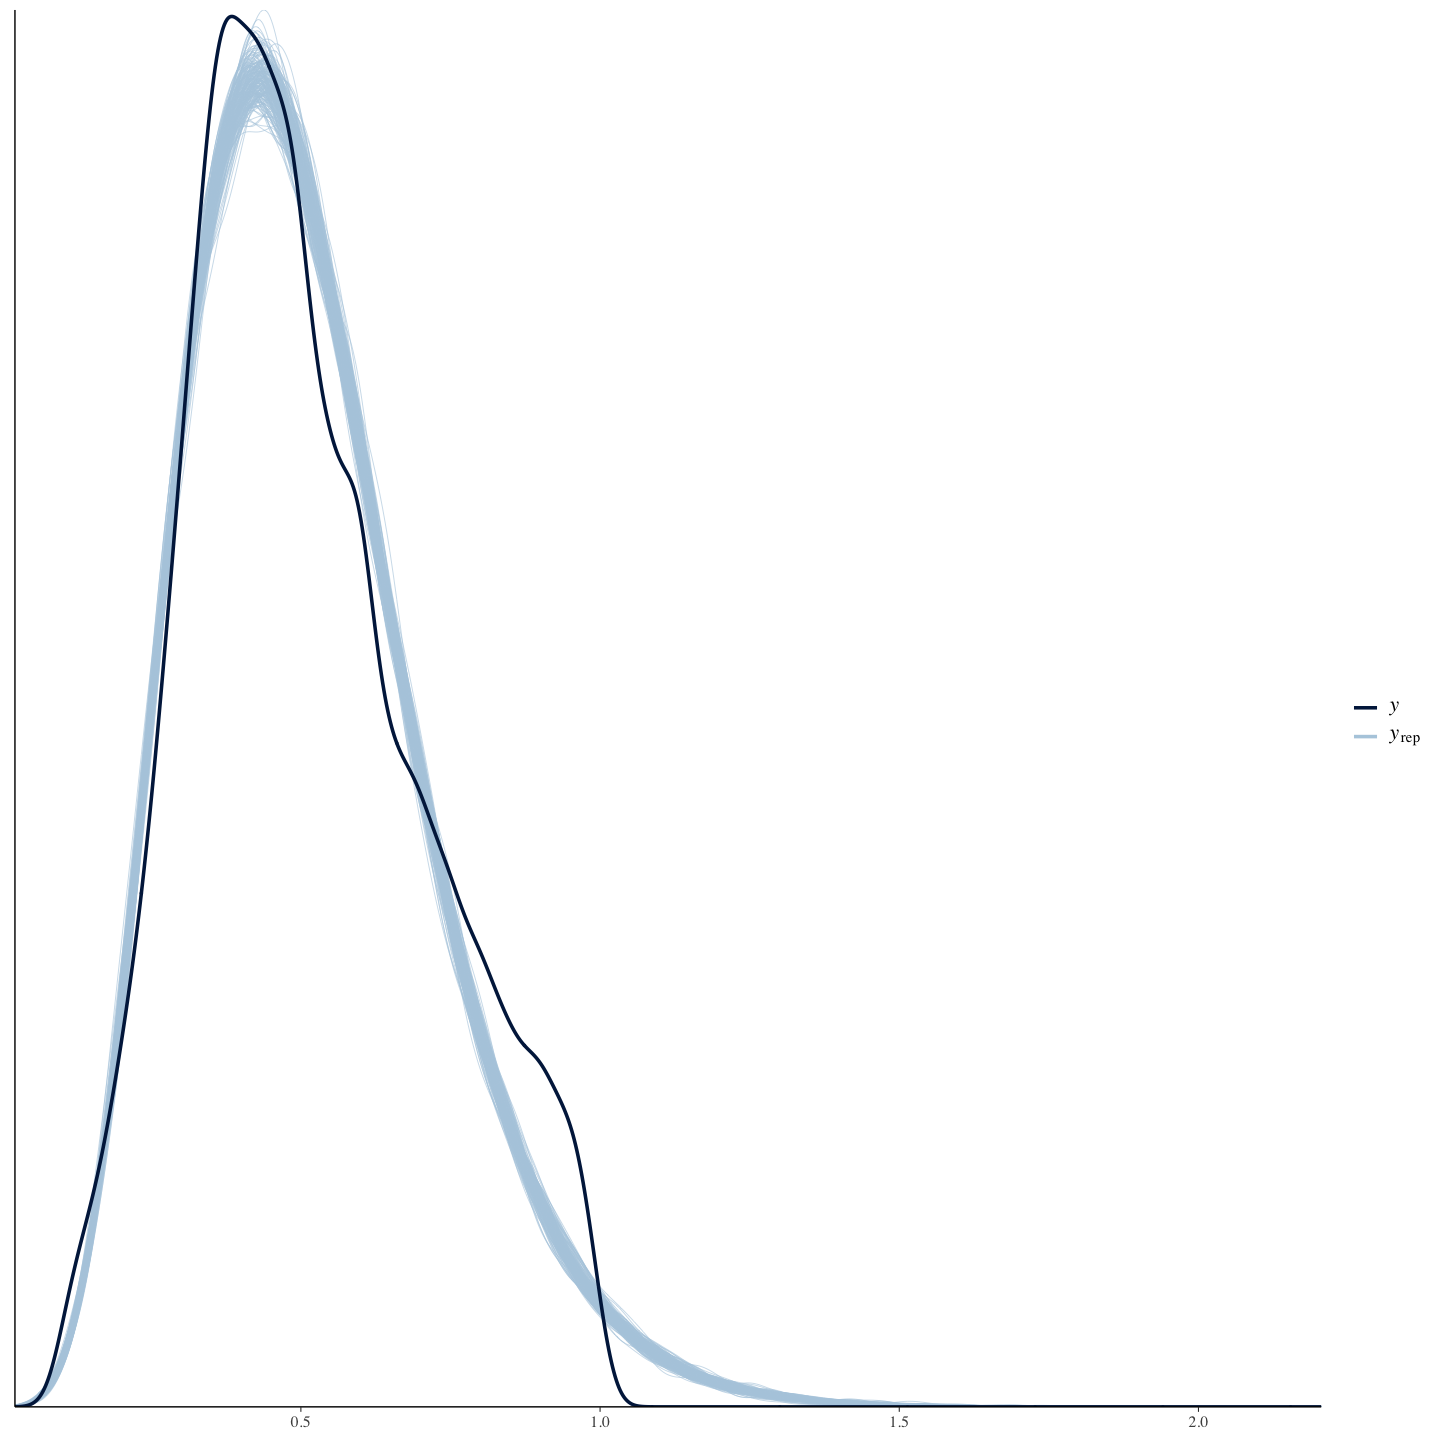

In [29]:
pp_check(fit2,nsamples = 200)

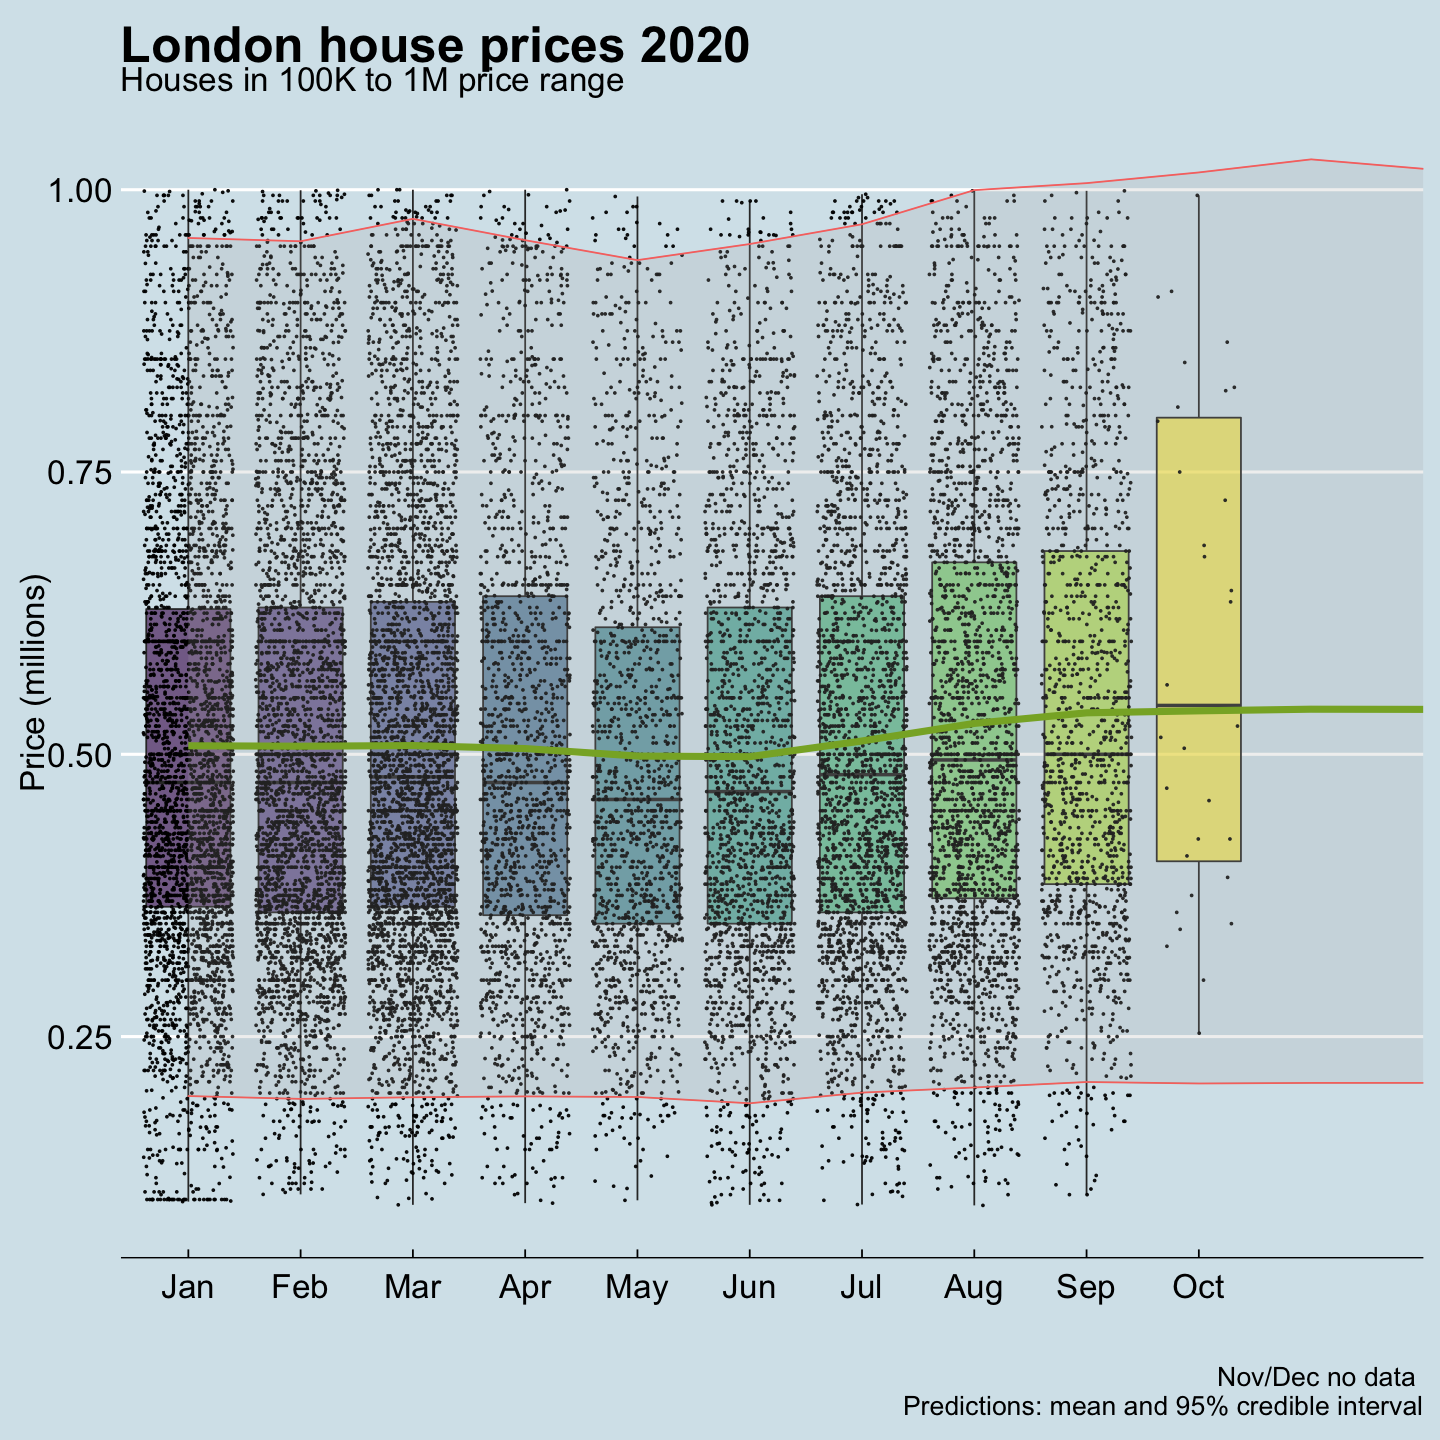

In [63]:
newdata <- data.frame("Month" = rep(seq(1,12),100))
preds2 <- predict(fit2, newdata = newdata,nsamples = 200)
preds_df2 = data.frame(preds2)
preds_df2 <- bind_cols(newdata,preds_df2)

preds_df2 <- aggregate(.~Month,data=preds_df2,FUN=mean)

df.ldn.tmp.f <- df.ldn.tmp
df.ldn.tmp.f$"Month" <- as.factor(df.ldn.tmp.f$"Month")

  ggplot() +
    theme_economist() + 
    scale_x_discrete(labels= c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec")) +
    theme(legend.position="none") +
    xlab("Month") + ylab("Price (millions)") +  
    labs(title = "London house prices 2020",
        subtitle = "Houses in 100K to 1M price range",
        caption ="\nNov/Dec no data \nPredictions: mean and 95% credible interval") +
    
    geom_boxplot(data=df.ldn.tmp.f, aes(x=Month, y=PricePaid, fill=Month)) +
    scale_fill_viridis(discrete = TRUE, alpha=0.6) +
    geom_jitter(data=df.ldn.tmp.f, aes(x=Month, y=PricePaid),color="black", size=0.4, alpha=0.9) +
     theme(text = element_text(size = 20),legend.title = element_blank())  +
    geom_line(data = preds_df2, aes(y=Estimate, x=Month, col="Mean pred"), size = 2)   +
     geom_line(data = preds_df2,aes(y=Q2.5, x=Month,col="Q2.5"), size = 0.2) +
    geom_line(data = preds_df2,aes(y=Q97.5, x=Month,col="Q97.5"), size = 0.2) +
    geom_ribbon(data = preds_df2,
        aes(ymin = Q2.5, ymax = Q97.5,x=Month, col="CrI 95%"), fill = "grey70", alpha = 0.2)  +
    theme(text = element_text(size = 20),legend.title = element_blank()) + 
    xlab("") 

In [60]:
newdata <- data.frame("Month" = rep(seq(1,12),100))
preds2 <- predict(fit2, newdata = newdata,nsamples = 200)
preds2 = data.frame(preds2)
preds2 <- bind_cols(newdata,preds2)

preds2$sd_lower = preds2$Estimate - (preds2$Estimate - preds2$Q2.5)/sqrt(length(preds2$Estimate))
preds2$sd_upper = preds2$Estimate + ( preds2$Q97.5 -preds2$Estimate)/sqrt(length(preds2$Estimate))

preds_df2 <- aggregate(.~Month,data=preds2,FUN=mean)

In [61]:
df_grow = data.frame("Month" = preds_df2$"Month",
                    "Growth" = 100*(preds_df2$Estimate - preds_df2$Estimate[1])/preds_df2$Estimate[1],
                    "G_up" = 100*(preds_df2$sd_upper - preds_df2$Estimate[1])/preds_df2$Estimate[1],
                    "G_low" = 100*(preds_df2$sd_lower - preds_df2$Estimate[1])/preds_df2$Estimate[1])

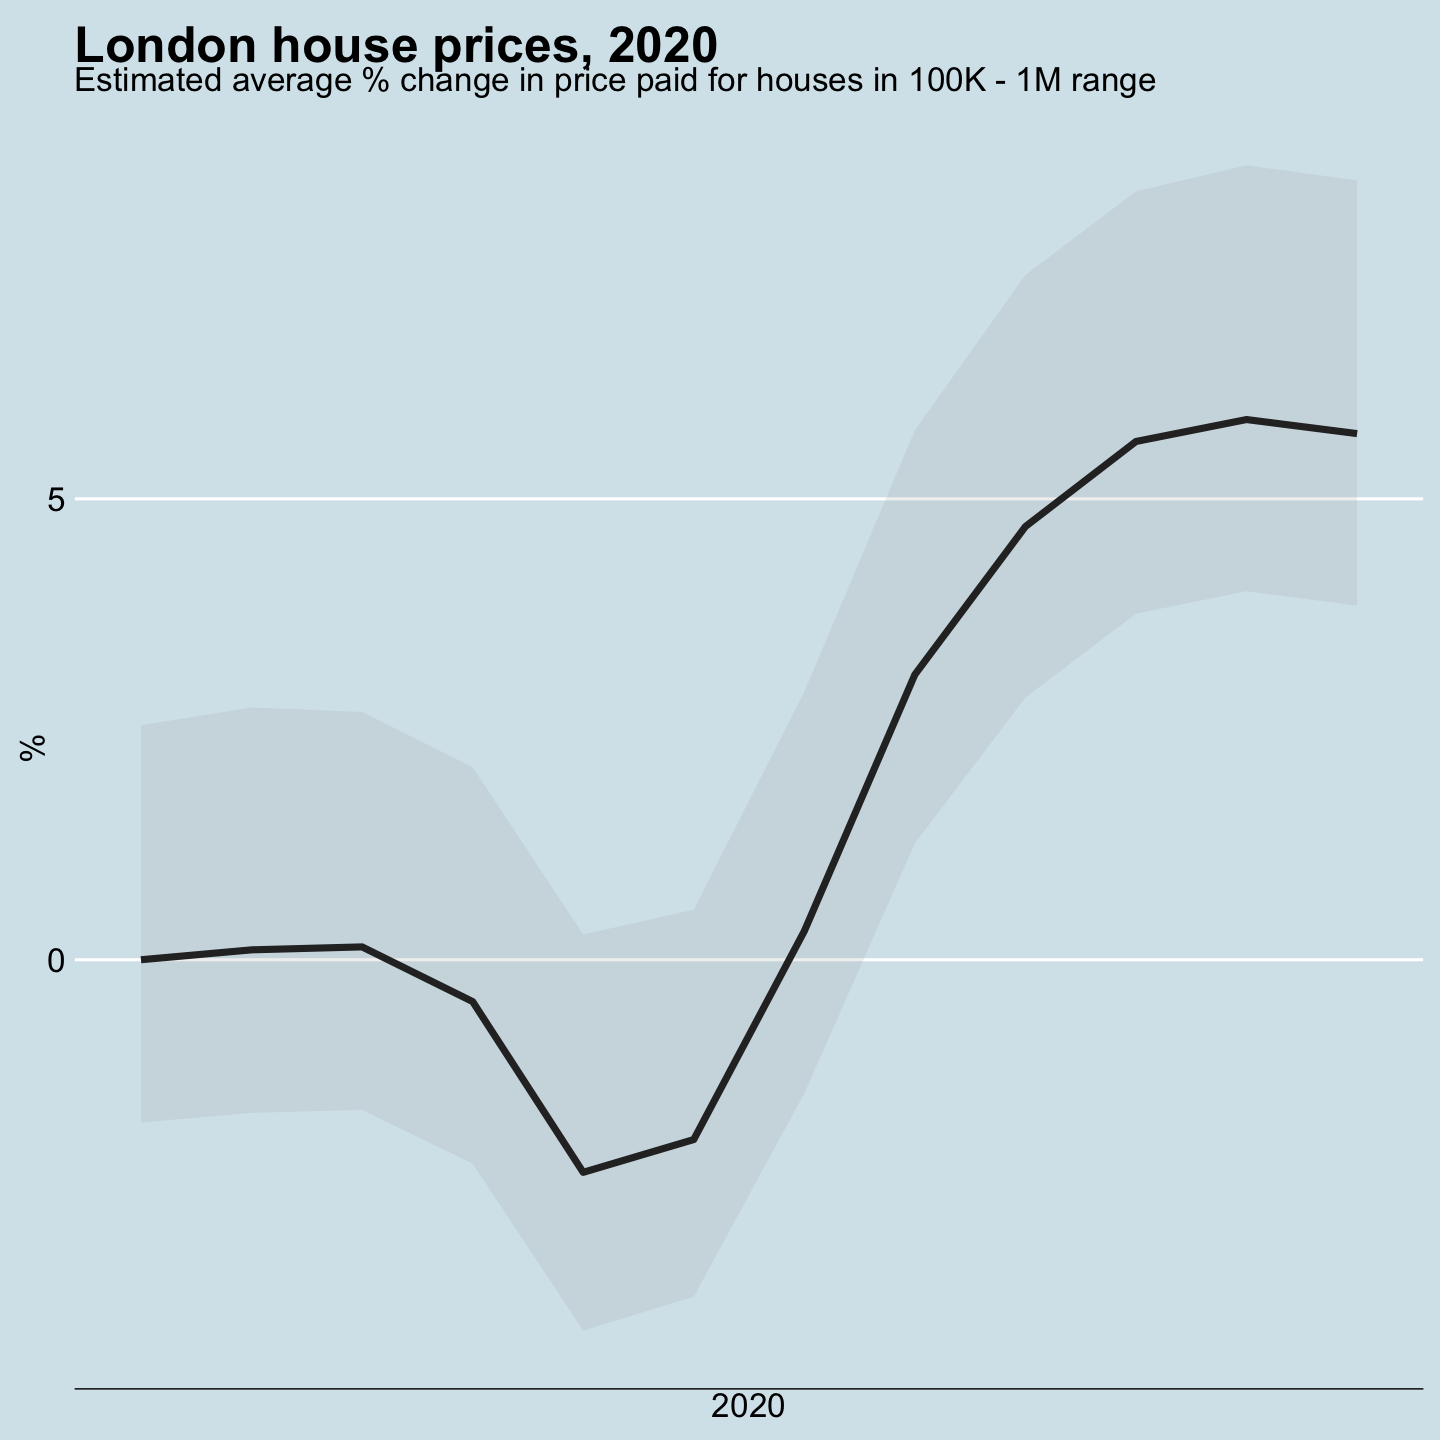

In [69]:
df_grow %>% ggplot() + geom_line(aes(x = Month, y = Growth),size = 2) +
     geom_ribbon(aes(ymin = G_low, ymax = G_up, x=Month), fill = "grey70", alpha = 0.2) +
    theme_economist() + 
    theme(legend.position="none") +
    ylab("%")  +
    labs(title = "London house prices, 2020",
              subtitle = "Estimated average % change in price paid for houses in 100K - 1M range") +
    theme(text = element_text(size = 20),legend.title = element_blank())  + xlab("2020") +
    scale_x_discrete(labels= c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"))